### Our training (or test) dataset includes synthesized facies models, corresponding global features, well facies dataset, and probability maps. 

#### In our study, facies models (2D, 64x64) are generated using the object-based modeling method, in Petrel software. 
Synthesized facies models are exported from Petrel as model properties with "Gslib" format into one file. 


First lines of the exported file are like:

PETREL: Properties

17820  % Number of synthesized facies models


Facies unit1 scale1  

Facies unit1 scale1

...

Facies unit1 scale1

% Totally, there are 64x64 lines, corresponding to 64x64 pixels in each facies model; each line has 17820 numbers splitted by space, corresponding to 17820 facies code values of 17820 generated facies realizations at each pixel. 0-background mud faceis, 1-channel sand facies, 2-channel bank facies. 

0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 ... 0.000000 1.000000 2.000000

0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 ... 0.000000 0.000000 0.000000

...

0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 ... 0.000000 0.000000 0.000000



The 17820 facies models in this file will be enlarged (by reversing the 17820 facies models) and arranged into (35640, 1, 64, 64) in the following code.

Other software, like SGeMS, can also be used, as long as the final generated facies models are arranged into (N, 1, 64, 64).


#### Original global features (as labels in this file) include channel orientation, channel width, channel wavelength, and channel amplitude, which are corresponding input parameters when synthesizing facies models with object-based method. We further add background mud proportion and channel sinuosity index global features. 

#### Probability maps are produced from the synthesized facies models using Gaussian kernel smoothing method.


#### Well facies data are sampled from the probability data . 


### 1 Write paths
#### Filepath: path of synthesized facies models
#### labels_path: path of global features (labels) corresponding to facies models
#### tfrecord_dir_training: directory to save training dataset
#### tfrecord_dir_test: directory to save test dataset

In [1]:
Filepath = '/home/users/suihong/training_data/TrainingData(MultiChannels_Version4)/2D_AllPro_Gslib_fromPetrel(version4)' 
labels_path = '/home/users/suihong/training_data/TrainingData(MultiChannels_Version4)/labels(version4).txt' 
tfrecord_dir_training = '/scratch/users/suihong/DataSets(MultiChannels_Version4_Consistency)/TrainingData'
tfrecord_dir_test = '/scratch/users/suihong/DataSets(MultiChannels_Version4_Consistency)/TestData'

### 2 Load facies models

In [2]:
import numpy as np
import tensorflow as tf
import os

In [3]:
allele=[]  
# stores all facies code values of the file. includes 64x64 lists, and each list includes code values of all realizations at each pixel.

with open (Filepath) as fl:
    for line in fl:
        eles = line.strip().split(' ')
       
        if len(eles)>=5:    # filter the lines with property name "Facies unit1 scale1"        
            allele.append(eles)
            
rlz_no = len(allele[0]) # number of realizations


In [4]:
partimgs = np.array(allele, dtype = float).reshape((64, 64, rlz_no)).astype(int)
partimgs = np.where(partimgs == 1, 4, partimgs)/2 * 127.5 # originally, 1 for channel sand facies, and 2 for channel bank; here exchange their codes.
# The orientation of the original simulated facies models is only from 0-90, thus we enlarge the facies model dataset by reversing it vertically to add facies models with orientation from -90 to 0.  
allimgs = np.concatenate((partimgs, partimgs[::-1,:,:]),2)  # partimgs[::-1,:,:] to reverse partimgs vertically: original partimgs 
allimgs = np.transpose(allimgs, (2, 0, 1))  # transpose into (?, 64, 64) dimension
allimgs = allimgs.reshape(-1, 1, 64, 64)

In [5]:
print(allimgs.shape)

(35640, 1, 64, 64)


In [6]:
del(allele)

### 3 Generate probability maps

In [7]:
print(([allimgs.shape[0]]+[8]+[*allimgs.shape[1:]]))

[35640, 8, 1, 64, 64]


In [8]:
# define Guassian kernel
from scipy.stats import multivariate_normal
def norm_kernel(size = 9, sigma = 2):
    sig = sigma * np.eye(2)
    mean = np.zeros(2,)
    size_min = -(size - 1)/2
    size_max = (size - 1)/2
    x = np.linspace(size_min, size_max, size)
    y = np.linspace(size_min, size_max, size)
    xk, yk = np.meshgrid(x, y)
    kernel = np.zeros((size,size), dtype=np.float32)
    for i in range(size):
        for j in range(size):
            coord = np.squeeze([xk[i,j], yk[i,j]])
            kernel[i,j] = multivariate_normal.pdf(coord, mean=mean, cov=sig)
    kernel_sum = np.sum(kernel)
    kernel = kernel / kernel_sum
    return kernel

In [ ]:
# Using Gaussian kernels with various size to smooth the indicator of channel complex to form the probability maps of channel complex with various blurriness. 

import scipy.signal as sig
prob_rlzs = np.zeros(([allimgs.shape[0]]+[8]+[*allimgs.shape[1:]]), dtype=np.float32) # dimension = [35640, 8, 1, 64, 64]  
count = 0
for k in range(13,28,2):
    kernel = norm_kernel(size = k, sigma = k)  # size should be set to be odd
    for num in range(allimgs.shape[0]):
        cur_image = allimgs[num,0]/255.0
        padvalue = np.mean(cur_image)
        prob_image = sig.convolve2d(cur_image, kernel, fillvalue = padvalue, mode='same') 
        prob_rlzs[num, count, 0] = prob_image 
            
    count = count + 1    

In [ ]:
print(prob_rlzs.shape)

#### Test synthesized probability maps

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

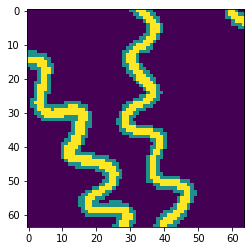

In [8]:
plt.imshow(allimgs[652,0])

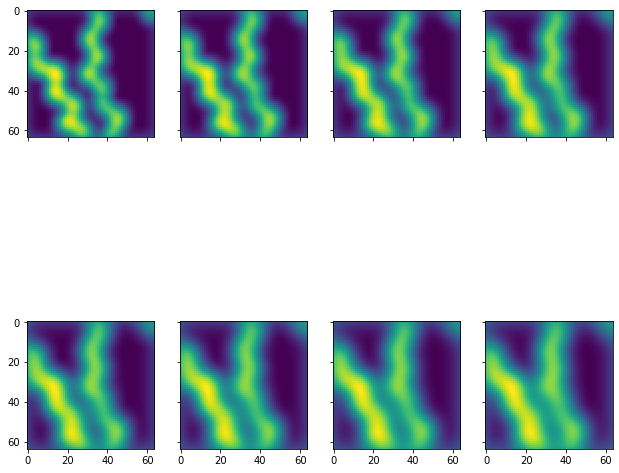

In [13]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row')
fig.set_size_inches(10.5, 10.5, forward=True)
  
for i in range (2):
  for j in range(4):
    ax[i, j].imshow(prob_rlzs[652, i*4 + j,0,:,:])

In [14]:
prob_rlzs = prob_rlzs.reshape(-1,1, 64, 64) 

In [15]:
print(prob_rlzs.shape)

(285120, 1, 64, 64)


### 4 Generate well facies

In [16]:
# Generate random well points

well_points = np.zeros(prob_rlzs.shape, dtype = int)
for i in range(prob_rlzs.shape[0]):
    well_points_num = np.random.choice(np.arange(1, 21), 1)  # Random choose the expected total number of well points
    xs = np.random.choice(64, well_points_num)
    ys = np.random.choice(64, well_points_num)
    well_points[i, 0, xs, ys] = 1

In [17]:
Prob_rlzs_max = np.max(prob_rlzs, axis = (2, 3), keepdims = True)
Prob_rlzs_min = np.min(prob_rlzs, axis = (2, 3), keepdims = True)
well_facies = well_points * (prob_rlzs - Prob_rlzs_min)/(Prob_rlzs_max - Prob_rlzs_min)

In [18]:
# Sample well facies according to calculated probability maps.
well_facies = np.where(well_facies<=0.4, 0, well_facies)  

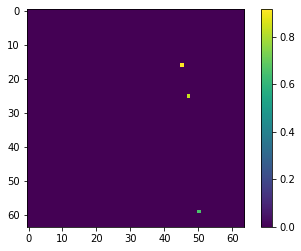

In [19]:
plt.imshow(well_facies[664,0])
plt.colorbar()

In [20]:
well_facies_random = np.random.uniform(0,1,well_facies.shape)
well_facies = np.where(well_facies_random<well_facies, 1, 0) + well_points

#### Test synthesized well facies data

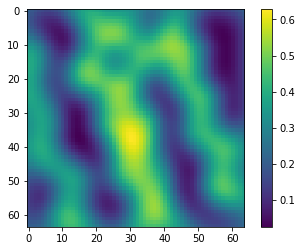

In [21]:
plt.imshow(prob_rlzs[28994,0])
plt.colorbar()

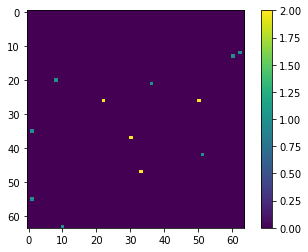

In [22]:
plt.imshow(well_facies[28994,0])
plt.colorbar()

### 5 Load labels (Global features)

In [93]:
labels_list=[]  # store all labels of the file. 
with open (labels_path) as lb:  # read label file
    for line in lb:
        labels_list.append(line.strip().split('  '))

ori_labels_no = len(labels_list) # number of labels in the opened file
ori_labels_arr=np.array(labels_list, dtype=np.float).reshape(ori_labels_no, 5).astype(np.float)

all_labels_arr = np.empty((ori_labels_no*6,5), dtype=np.float)

# Every label corresponds to 3 consecutive facies models, thus labels are mutiplied by 3.
all_labels_arr[:ori_labels_no*3:3,:]=ori_labels_arr
all_labels_arr[1:ori_labels_no*3:3,:]=ori_labels_arr
all_labels_arr[2:ori_labels_no*3:3,:]=ori_labels_arr

# When facies models are enlarged by reversing vertically; the orientation of reversed facies models is from -90 to 0 degree. 
all_labels_arr[:,1]=all_labels_arr[:,1]*(-1) # orientation is negativized. 

# Other labels for the reversed facies models remain the same. 
all_labels_arr[ori_labels_no*3:ori_labels_no*6:3,:]=ori_labels_arr
all_labels_arr[ori_labels_no*3+1:ori_labels_no*6:3,:]=ori_labels_arr
all_labels_arr[ori_labels_no*3+2:ori_labels_no*6:3,:]=ori_labels_arr


In [94]:
print(all_labels_arr.shape)

(35640, 5)


In [95]:
labels_cor = np.empty((all_labels_arr.shape[0], 4), dtype=np.float)  
orit = all_labels_arr[:, 1]   # Orientation is placed in the first column

# labels_cor include orientation of channels, inter-channel mud facies ratio, width of channel sand, and sinuosity index (amplitude/wavelength) of channel sand
# at the range of -1 to 1
labels_cor[:,0] = ((orit - np.min(orit))/(np.max(orit) - np.min(orit)) - 0.5) * 2  

back_ratio = 1-np.count_nonzero(allimgs, (1,2,3))/(64*64)
labels_cor[:,1] = ((back_ratio - np.min(back_ratio))/(np.max(back_ratio) - np.min(back_ratio)) - 0.5) * 2

width = all_labels_arr[:, 2]
labels_cor[:,2] = ((width - np.min(width ))/(np.max(width ) - np.min(width )) - 0.5) * 2
    
amwv_ratio = all_labels_arr[:, 4]/all_labels_arr[:, 3]  #amplitude to wavelength ratio
### Important: set amplitude/wavelength to be 0.55 when it is larger than 0.55, because the sinuosity level of channels can not be more apparent even when that ratio is larger.
amwv_ratio = np.where(amwv_ratio> 0.55, 0.55, amwv_ratio)
labels_cor[:,3] = ((amwv_ratio  - np.min(amwv_ratio ))/(np.max(amwv_ratio ) - np.min(amwv_ratio )) - 0.5) * 2

### 6 Generate training and test datasets

In [90]:
# Randomly split facies models into training and test dataset
randseq=np.random.RandomState(232).permutation(allimgs.shape[0])
allimgs_training = allimgs[randseq[:32640]]
allimgs_test = allimgs[randseq[32640:]]
print(allimgs_training.shape)
print(allimgs_test.shape)

(32640, 1, 64, 64)
(3000, 1, 64, 64)


In [96]:
# Corresponding split global features into training and test dataset
labels_cor_training = labels_cor[randseq[:32640]]
labels_cor_test = labels_cor[randseq[32640:]]
print(labels_cor_training.shape)
print(labels_cor_test.shape)

(32640, 4)
(3000, 4)


#### Option 1 Building consistent training dataset

##### This block is used when building consistent training dataset, where facies models, global features, well facies, and probmaps are consistent

In [36]:

# Randomly split probability maps into training and test dataset
prob_rlzs=prob_rlzs.reshape(-1,8, 64, 64) 
prob_rlzs_training = prob_rlzs[randseq[:32640]].reshape(-1,1, 64, 64)
prob_rlzs_test = prob_rlzs[randseq[32640:]].reshape(-1,1, 64, 64)

# Randomly split well facies data into training and test dataset
well_facies=well_facies.reshape(-1, 8, 64, 64)
well_facies_training = well_facies[randseq[:32640]].reshape(-1,1, 64, 64)
well_facies_test = well_facies[randseq[32640:]].reshape(-1,1, 64, 64)

# Keep random one of the 8 probmaps and one of the 8 well facies data in training dataset. Test dataset still have 8 probmaps and 8 well facies
proborder = np.arange(32640) * 8 + np.random.RandomState(32).randint(0, 8, size=32640)
prob_rlzs_training = prob_rlzs_training[proborder]
well_facies_training = well_facies_training[proborder]

print(prob_rlzs_training.shape)
print(well_facies_training.shape)

(32640, 1, 64, 64)
(32640, 1, 64, 64)


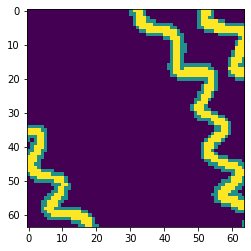

In [91]:
plt.imshow(allimgs_training[1225,0])

In [15]:
print(labels_cor[randseq[1225]])

[-0.35714286  0.60753341 -1.          1.        ]


In [16]:
print(labels_cor_training[1225])

[-0.35714286  0.60753341 -1.          1.        ]


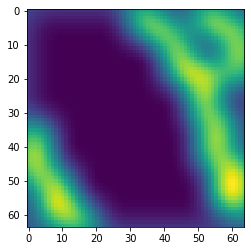

In [63]:
plt.imshow(prob_rlzs_training[1225,0])

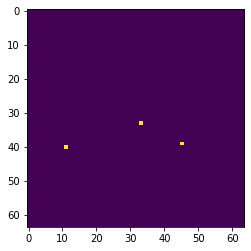

In [64]:
plt.imshow(well_facies_training[1225,0])

#### Option 2 Building non-consistent training dataset

##### This block is used when building non-consistent training dataset, where only facies models and global features are consistent.

In [98]:
# Randomly split probability maps into training and test dataset
# prob_rlzs=prob_rlzs.reshape(-1,8, 64, 64) 
# prob_rlzs_training = prob_rlzs[randseq[:32640]].reshape(-1,1, 64, 64)
# prob_rlzs_test = prob_rlzs[randseq[32640:]].reshape(-1,1, 64, 64)
# print(prob_rlzs_training.shape)
# print(prob_rlzs_test.shape)

(261120, 1, 64, 64)
(24000, 1, 64, 64)


In [99]:
# shuffle probability maps again, there are 8 probability maps correpsonding to 1 facies models, and the 8 maps are in order
# prob_randseq=np.random.permutation(prob_rlzs_training.shape[0])
# prob_rlzs_training = prob_rlzs_training[prob_randseq] 

# Randomly split well facies data into training and test dataset
# well_facies=well_facies.reshape(-1, 8, 64, 64)
# well_facies_training = well_facies[randseq[:32640]].reshape(-1,1, 64, 64)
# well_facies_test = well_facies[randseq[32640:]].reshape(-1,1, 64, 64)
# print(well_facies_training.shape)
# print(well_facies_test.shape)

# well_facies_training = well_facies_training[prob_randseq]

(261120, 1, 64, 64)
(24000, 1, 64, 64)


In [100]:
# print(well_facies_training.shape)

(261120, 1, 64, 64)


#### Store training dataset

In [104]:
from scipy import stats
# copy from ProGAN github dataset_tools.py
class TFRecordExporter:
    def __init__(self, tfrecord_dir, expected_images, print_progress=True, progress_interval=10):
        self.tfrecord_dir       = tfrecord_dir
        self.tfr_prefix         = os.path.join(self.tfrecord_dir, os.path.basename(self.tfrecord_dir))
        self.expected_images    = expected_images
        self.cur_images         = 0
        self.shape              = None
        self.resolution_log2    = None
        self.tfr_writers        = []
        self.print_progress     = print_progress
        self.progress_interval  = progress_interval
        if self.print_progress:
            print('Creating dataset "%s"' % tfrecord_dir)
        if not os.path.isdir(self.tfrecord_dir):
            os.makedirs(self.tfrecord_dir)
        assert(os.path.isdir(self.tfrecord_dir))
        
    def close(self):
        if self.print_progress:
            print('%-40s\r' % 'Flushing data...', end='', flush=True)
        for tfr_writer in self.tfr_writers:
            tfr_writer.close()
        self.tfr_writers = []
        if self.print_progress:
            print('%-40s\r' % '', end='', flush=True)
            print('Added %d images.' % self.cur_images)

    def choose_shuffled_order(self): # Note: Images and labels must be added in shuffled order.
        order = np.arange(self.expected_images)
        np.random.RandomState(123).shuffle(order)
        return order

    def add_real_image(self, real_img):
        if self.print_progress and self.cur_images % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_images, self.expected_images), end='', flush=True)
        if self.shape is None:
            self.shape = real_img.shape
            self.resolution_log2 = int(np.log2(self.shape[1]))
            assert self.shape[0] in [1, 3]
            assert self.shape[1] == self.shape[2]
            assert self.shape[1] == 2**self.resolution_log2
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            for lod in range(self.resolution_log2 - 1):
                tfr_file = self.tfr_prefix + '-1r%02d.tfrecords' % (self.resolution_log2 - lod)
                self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
        assert real_img.shape == self.shape
        for lod, tfr_writer in enumerate(self.tfr_writers[:-1]):
            if lod:
                real_img = real_img.astype(np.float32)
                
                # used to produce low-D with most frequent facies code
                #real_img_t = np.expand_dims(real_img, axis = 3)
                #real_img_t_c = np.concatenate((real_img_t[:, 0::2, 0::2], real_img_t[:, 0::2, 1::2], real_img_t[:, 1::2, 0::2], real_img_t[:, 1::2, 1::2]), axis = 3)                
                #mode, _ = stats.mode(real_img_t_c, axis = 3)
                #real_img = np.squeeze(mode, axis = 3)
                
                # used to produce low-D with averaging method
                real_img = (real_img[:, 0::2, 0::2] + real_img[:, 0::2, 1::2] + real_img[:, 1::2, 0::2] + real_img[:, 1::2, 1::2]) * 0.25
            
            quant = np.rint(real_img).clip(0, 255).astype(np.uint8)
            ex = tf.train.Example(features=tf.train.Features(feature={
                'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
                'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
            tfr_writer.write(ex.SerializeToString())
        self.cur_images += 1
        
        
    def add_prob_image(self, prob_image):
        if self.print_progress and self.cur_images % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_images, self.expected_images), end='', flush=True)
        if self.shape is None:
            self.shape = prob_image.shape
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            # add probimages writer into self.tfr_writers    
            tfr_file = self.tfr_prefix + '-2probimages.tfrecords' 
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
        # Writting prob_image into tfrecord file
        quant = prob_image.clip(0, 1).astype(np.float16)
        ex = tf.train.Example(features=tf.train.Features(feature={
            'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
            'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
        self.tfr_writers[0].write(ex.SerializeToString())
        self.cur_images += 1           

    def add_well_facies(self, well_facies):
        if self.print_progress and self.cur_images % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_images, self.expected_images), end='', flush=True)
        if self.shape is None:
            self.shape = well_facies.shape
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            # add well_facies writer into self.tfr_writers    
            tfr_file = self.tfr_prefix + '-3wellfacies.tfrecords' 
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
        # Writting well_facies into tfrecord file
        quant = well_facies.astype(np.uint8)
        ex = tf.train.Example(features=tf.train.Features(feature={
            'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
            'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
        self.tfr_writers[0].write(ex.SerializeToString())
        self.cur_images += 1           
        
        
    def add_labels(self, labels):
        if self.print_progress:
            print('%-40s\r' % 'Saving labels...', end='', flush=True)
        assert labels.shape[0] == self.cur_images
        with open(self.tfr_prefix + '-4rxx.labels', 'wb') as f:
            np.save(f, labels.astype(np.float32))

    def __enter__(self):
        return self
    
    def __exit__(self, *args):
        self.close()

In [105]:
with TFRecordExporter(tfrecord_dir_training, allimgs_training.shape[0]) as tfr:
    order = tfr.choose_shuffled_order()
    for idx in range(order.size):
        tfr.add_real_image(allimgs_training[order[idx]])
    tfr.add_labels(labels_cor_training[order])       

Creating dataset "/scratch/users/suihong/DataSets(MultiChannels_Version4_Consistency)/TrainingData"
Added 32640 images.                     


In [67]:
with TFRecordExporter(tfrecord_dir_training, prob_rlzs_training.shape[0]) as tfr:
    for idx in range(prob_rlzs_training.shape[0]):
        tfr.add_prob_image(prob_rlzs_training[idx])     

Creating dataset "/scratch/users/suihong/DataSets(MultiChannels_Version4_Consistency)/TrainingData"
Added 32640 images.                     


In [68]:
with TFRecordExporter(tfrecord_dir_training, well_facies_training.shape[0]) as tfr:
    for idx in range(well_facies_training.shape[0]):
        tfr.add_well_facies(well_facies_training[idx])     

Creating dataset "/scratch/users/suihong/DataSets(MultiChannels_Version4_Consistency)/TrainingData"
Added 32640 images.                     


#### Store test dataset

In [69]:
with TFRecordExporter(tfrecord_dir_test, allimgs_test.shape[0]) as tfr:
    for idx in range(allimgs_test.shape[0]):
        tfr.add_real_image(allimgs_test[idx])
    tfr.add_labels(labels_cor_test)       

Creating dataset "/scratch/users/suihong/DataSets(MultiChannels_Version4_Consistency)/TestData"
Added 3000 images.                      


In [70]:
with TFRecordExporter(tfrecord_dir_test, prob_rlzs_test.shape[0]) as tfr:
    for idx in range(prob_rlzs_test.shape[0]):
        tfr.add_prob_image(prob_rlzs_test[idx])     

Creating dataset "/scratch/users/suihong/DataSets(MultiChannels_Version4_Consistency)/TestData"
Added 24000 images.                     


In [71]:
with TFRecordExporter(tfrecord_dir_test, well_facies_test.shape[0]) as tfr:
    for idx in range(well_facies_test.shape[0]):
        tfr.add_well_facies(well_facies_test[idx])     

Creating dataset "/scratch/users/suihong/DataSets(MultiChannels_Version4_Consistency)/TestData"
Added 24000 images.                     
